# Implement Decision Tree Classifier from Scratch

### Task 1 : Import Necessary libraries

In [1]:
import numpy as np
import pandas as pd
from pprint import pprint
from numpy import log2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
df = pd.read_csv('/usercode/heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
eps = np.finfo(float).eps
target = df.keys()[-1]

In [4]:
print(eps)
print(target)

2.220446049250313e-16
HeartDisease


# The Decision Tree ID 3 Algorithm

## Task 2: Calculate the Entropy of a Feature

In this task, you’ll implement the code for the decision tree classifier. The ID3 algorithm recursively builds the tree one stump at a time. The feature with the highest information gain is selected as the decision stump at each step. If the targets become pure for any feature class, the target class is returned as a leaf node.

To complete this task, implement the entropy_of_feature() method that will compute and return the entropy of a feature in a given DataFram

The entropy_of_feature() method will accept the following parameters:

df: This is the DataFrame in which the entropy needs to be calculate
d.
feature: This is the name of the feature whose entropy needs to be calculat

Entropy of a feature ( formula ) : 

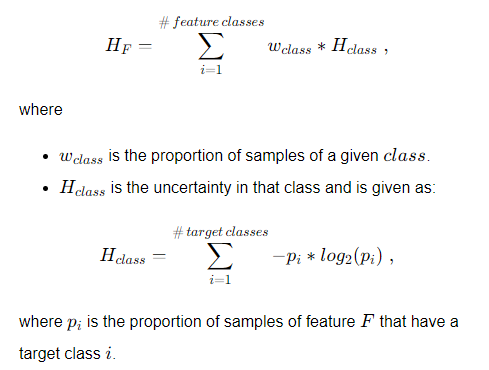ed.e.

In [5]:
def entropy_of_feature(df,feature):
    targets = df[target].unique()
    classes = df[feature].unique()
    entropy2 = 0
    for feature_class in classes:
        entropy = 0
        for target_class in targets:
            num = len(df[feature][df[feature]==feature_class][df[target]==target_class])
            den = len(df[feature][df[feature]==feature_class])
            fraction = num/(den+eps)
            entropy += -fraction*log2(fraction+eps)
        fraction2 = den/len(df)
        entropy2 += fraction2*entropy
    return entropy2

## Task 3: Select the Best Feature

To complete this task, we write code for the best_feature() method, which will be used to select the best feature for creating the decision stump at each step. The criteria for selecting the best feature is information gain, given by the following formula:

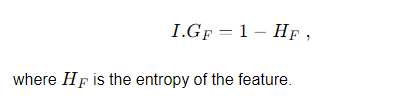

In [6]:
def best_feature(_df):
    IG = []
    features = list(set(_df.keys())- set([target]))
    for key in features:
        IG.append(1-entropy_of_feature(_df,key))
    result = features[np.argmax(IG)]
    return result

## Task 4: Retrieve the Sub-table

write the get_subtable() method. This method should return a subtable of the DataFrame.

   
_data: This is the input DataFram
e   .
node: This is the selected (best) featu
r   e.
value: This is a class of the selected feat
ure.
At each step, generate a table containing only a single class of the selected feature so that a tree can be recursively built for that branch. Also, remove the feature selected as the stump from the DataF
rame.

In [7]:
def get_subtable(_data, node, value):
    data = _data.copy()
    data = data[data[node] == value][list(set(data.columns)-set([node]))]
    return data.reset_index(drop=True)

## Task 5: Build the Decision Tree

write the build_tree() method for recursively creating the decision tree. This method will return the N-ary tree as a Python dictionary. In the build_tree() method, select the feature with the highest information gain using the best_feature() method and perform the following for each class in that feature:

Get the subtable using the get_subtable() method.
Because you’re working on a disease classification dataset, return the default value of 1 if the generated subtable has no samples or features.
If the target class of the DataFrame becomes pure, return that class. Otherwise, call the build_tree() method recursively to grow the tree.

In [8]:
def build_tree(_df,tree=None):

    node = best_feature(_df)

    nodeClasses = np.unique(_df[node])

    if tree is None:
        tree={}
        tree[node] = {}

    for nodeClass in nodeClasses:

        subtable = get_subtable(_df.copy(),node,nodeClass)
        clValue,counts = np.unique(subtable[target],return_counts=True)

        if len(counts)==1:
            return clValue[0]
        elif len(subtable)==0:
            return 1
        elif len(subtable.keys())==1:
            return 1
        else:
            tree[node][nodeClass] = build_tree(subtable)

    return tree

## Task 6: Generate Predictions

The predict() method takes the tree and the dataset as inputs and returns a list of predictions. It loops through the entire DataFrame and invokes the classify() method on each row.

The classify() method accepts a tree and a single row as input and recursively traverses the tree until it finds a class label.

In [9]:
def predict(tree, df):
    results = []
    for _, row in df.iterrows():
        res = classify(tree.copy(), row)
        results.append(res)
    return results

In [10]:
def classify(tree, row):
    feat = list(tree.keys())[0]

    if isinstance(tree[feat][row[feat]], dict):
        if row[feat] in tree[feat].keys():
            return classify(tree[feat][row[feat]].copy(), row)
        else:
            print('Unkown feature '+str(row[feat])+' in '+str(tree[feat].keys()))
    else:
        return tree[feat][row[feat]]

# Preprocess the Data

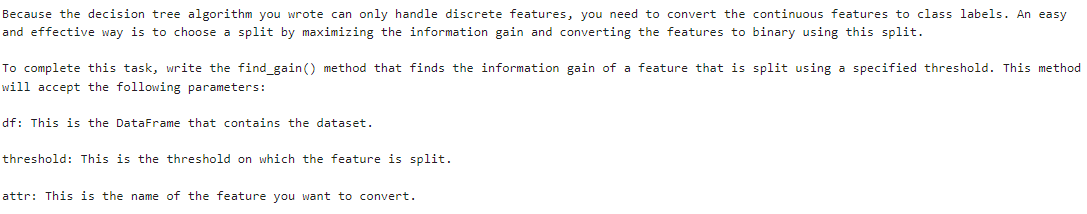
nvert.

## Task 7: Compute Information Gain of a Feature


In [11]:
def find_gain(df, threshold, attr):
    idx = df[df[attr] <= threshold].index

    tmp_df = df.copy()
    tmp_df[attr] = '>'+str(threshold)
    tmp_df.loc[idx, attr] = '<='+str(threshold)

    return 1-entropy_of_feature(tmp_df, attr)

## Task 8: Convert Continuous Feature to Binary

write the cont_2_binary() method, which converts continuous features to binary. This method will work by finding the best threshold for splitting the feature. Information gain will again be used as the criteria for the best threshold and will be computed for each unique value in the feature column. The column of the feature will then be used to cast each value as being either above or below that threshold.

In [12]:
def cont_2_binary(df, cont=None):
    df = df.copy()
    thresholds = {}
    cont_cols =  cont if cont else df._get_numeric_data().columns[:-1]
    for col in cont_cols:
        IG = []
        unique = sorted(df[col].unique())
        for uni in unique:
            IG.append(find_gain(df, uni, col))
        thresholds[col] = unique[np.argmax(IG)]
        idx = df[df[col] <= thresholds[col]].index

        df[col] = '>'+str(thresholds[col])
        df.loc[idx, col] = '<='+str(thresholds[col])

    return df

## Task 9: Preprocess the Data

Use the cont_2_binary() method declared in Task 8 to convert the continuous columns to binary.

Use the train_test_split() method of the sklearn.model_selection module to split the dataset into training and testing splits as follows
:
Use the test_size parameter to set the proportion of the test dataset relative to the original dataset. This method shuffles the dataset before splitting it to ensure uniform class distributio
n.
Use the random_state parameter when splitting the dataset to get reproducible resul
ts.

In [13]:
df = cont_2_binary(df)
df_train, df_test = train_test_split(df.sample(frac=1, random_state=1337).reset_index(drop=True), random_state=42, test_size=0.3)

df_train.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
712,<=54,F,NAP,<=140,>123,<=0,Normal,<=132,N,<=0.8,Up,0
477,<=54,M,ASY,<=140,>123,<=0,Normal,<=132,Y,>0.8,Flat,1
409,<=54,F,ATA,<=140,>123,<=0,Normal,>132,N,<=0.8,Up,0
448,>54,M,ASY,<=140,>123,<=0,Normal,<=132,N,>0.8,Flat,1
838,<=54,M,NAP,<=140,<=123,<=0,ST,>132,N,>0.8,Up,1


In [14]:
print(df_train.shape) , print(df_test.shape)

(642, 12)
(276, 12)


(None, None)

# Train, Predict, and Evaluate the Model

## Task 10: Train the Model and Make Predictions

Use the build_tree() method defined in Task 5 to construct the decision tree.

Print the decision tree as a Python dictionary
.
Use the predict() method defined in Task 6 to make predictions over the test se
t.

In [15]:
tree = build_tree(df_train)

In [16]:
pprint(tree)

{'ST_Slope': {'Down': {'ExerciseAngina': {'N': 0, 'Y': 1}},
              'Flat': {'ChestPainType': {'ASY': 1,
                                         'ATA': {'Sex': {'F': 0, 'M': 1}},
                                         'NAP': {'Sex': {'F': 0,
                                                         'M': {'MaxHR': {'<=132': 1,
                                                                         '>132': {'ExerciseAngina': {'N': {'RestingECG': {'LVH': 0,
                                                                                                                          'Normal': 1,
                                                                                                                          'ST': 1}},
                                                                                                     'Y': 0}}}}}},
                                         'TA': 1}},
              'Up': {'ChestPainType': {'ASY': {'Cholesterol': {'<=123': 1,
                      

In [17]:
results = predict(tree.copy(), df_test.iloc[:, :-1])
df_test['pred'] = results
df_test.head(10)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,pred
668,>54,M,ATA,>140,>123,<=0,Normal,>132,N,<=0.8,Up,0,0
30,>54,M,ASY,<=140,>123,<=0,Normal,<=132,Y,>0.8,Down,1,1
377,<=54,F,ATA,<=140,>123,<=0,Normal,>132,N,<=0.8,Up,0,0
535,>54,M,ASY,>140,<=123,>0,ST,<=132,N,<=0.8,Flat,1,1
807,>54,F,ASY,<=140,<=123,>0,Normal,>132,N,>0.8,Down,1,0
793,<=54,M,NAP,<=140,>123,<=0,Normal,<=132,Y,>0.8,Flat,1,1
363,>54,M,ASY,<=140,<=123,>0,Normal,<=132,Y,>0.8,Up,1,1
583,<=54,F,ATA,<=140,>123,<=0,ST,>132,N,<=0.8,Up,0,0
165,>54,M,ASY,<=140,>123,<=0,ST,>132,Y,>0.8,Flat,1,1
483,>54,M,NAP,>140,<=123,<=0,Normal,<=132,Y,<=0.8,Flat,1,1


## Task 11: Display the Confusion Matrix

Use the confusion_matrix() method from sklearn.metrics to get a confusion matrix. It accepts the following parameters:

y_true: The labels in the datas
et
y_pred: The predicted lab
els
Use the heatmap() method from the seaborn package to display the confusion matrix. It accepts the following parameters:

data: This is the data that will be used to construct the heatmap, i.e., the confusion m
atrix.
annot: This is a boolean for printing the data value of eac
h cell.
fmt: This determines the notation of the anno
tations.
cmap: This is the color scheme for the
 heatmap.
Use the following configurations for the plot:

plt.xlabel: This is the name of the x-axis, i.e., 
'Predicted'.
plt.ylabel: This is the name of the y-axis, 
i.e., 'True'.

Text(20.72222222222222, 0.5, 'True')

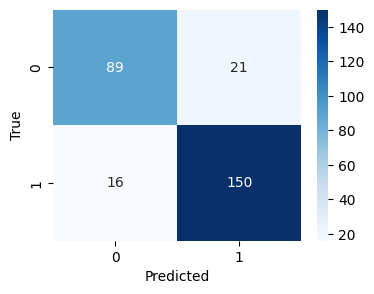

In [18]:
cm = confusion_matrix(df_test.loc[:, 'HeartDisease'], results)

plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')

## Task 12: Compute Evaluation Metrics

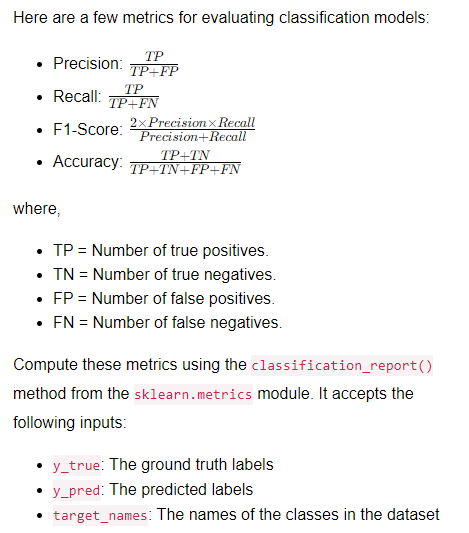

In [19]:
target_names = ['No Disease', 'Disease']
print(classification_report(df_test.loc[:, 'HeartDisease'], results, target_names=target_names))

              precision    recall  f1-score   support

  No Disease       0.85      0.81      0.83       110
     Disease       0.88      0.90      0.89       166

    accuracy                           0.87       276
   macro avg       0.86      0.86      0.86       276
weighted avg       0.87      0.87      0.87       276



# End